In [1]:
import fitsio
import easyaccess as ea
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import sys
import time
import subprocess
%matplotlib inline

multiply ligo map by 0.8 * 0.8 to get P_one. 
to get P_one = 0.999... 
what is the number N (how many events identical to this one do we need to get 0.999) that we need to multiply
mulitpy by the prob of it being real (0.5) from https://arxiv.org/pdf/1609.09517.pdf

P_i = SUM(e_spatial(0.8)*e_camera(0.8)*e_detection(robs plot)*e_bns(~.42))
P_one = 1 - prod(1-P_i)

### load in Rob's efficiencies plot to get avg

In [9]:
efficiencies = pd.read_csv('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/analysis/GW190510_cut_12_kn_efficiencies_table.csv')

In [10]:
print "MEAN:", efficiencies["EFFICIENCY"].mean()

MEAN: 0.4665003106872


## Do P_one calculation
$P_i = \Sigma_{\rm spatial} \times \epsilon_{ \rm camera} \times \epsilon_{\rm efficiency} \times \epsilon_{\rm real}$

$P_{\rm one} = 1 - \prod_{i}^{N}(1 - P_i)$

* **spatial**: the total prob of the even we covered
* **camera**: fraction of decam that is live that night (80%)
* **detection** (efficiency): value from Rob's plot -- our ability to detect the event
    * Mean efficiency = 0.47
    * val in blue square = 0.94
    * 80s exposure time: g_band = 74%, z_band = 90%, avge = 82%
* **prob**: the probability of this being a real event

In [15]:
for n in range(1,100): #100 is arbitrary

    spatial = 0.65 ## we covered 0.65
    camera = 0.8 
    detection = 0.82 
    prob = 0.42 #final lvc classification   
    
    P_i = (spatial * camera * detection * prob)
    p_array = np.full(n, P_i)
    P_one = 1 - np.cumprod(1-p_array)
    if P_one[-1]>=0.99: #total probability limit
        print P_one[-1] 
        print(n)
        sys.exit()

0.991227598503019
24


SystemExit: 

### Results:
#### Case 1: Avg efficiency
   * spatial = 0.65 #prob area enclosed
   * camera = 0.8 #fraction of the camera that is live
   * detection = 0.467
   * prob = 0.42
   * **50% (99%) = 7 (43) events**
   
#### Case 2: Blue component of 170817
   * spatial = 0.65 #prob area enclosed
   * camera = 0.8 #fraction of the camera that is live
   * detection = 0.94
   * prob = 0.42
   * **50% (99%) = 4 (21) events**
   
#### Case 3: Double exp time (80s) 
   * spatial = 0.65 #prob area enclosed
   * camera = 0.8 #fraction of the camera that is live
   * detection = 0.82
   * prob = 0.42
   * **50% (99%) = 4 (24) events**

## Looking at other bns/bhns events

In [25]:
#{name: prob of being NS}
eventsNS = {'S200213t': 0.63, 'S200105ae': 0.03, 'S191213g': 0.77, 'S191205ah': 0.93, 'S190930t': 0.74,
            'S190910h': 0.61, 'S190901ap': 0.86, 'S190814bv': 0.99, 'S190718y': 0.02, 'S190510g': 0.42 ,
            'S190426c': 0.49, 'S190425z': 0.99}
eventbhns = {'S190923y': 0.68,'S190910d': 0.98 }
#len(eventsNS)
len(eventsNS)
for key, val in eventsNS.iteritems():
    if val > 0.9:
        print key, val

S191205ah 0.93
S190425z 0.99
S190814bv 0.99


In [38]:
spatial = 0.90
camera = 0.80
detection = 0.75
prob = [0.93, 0.99, 0.99, 0.98]
pi = []
for p in prob:
    pi.append(spatial * camera * detection * p)
p_array = np.full(len(prob), pi)
P_one = 1 - np.cumprod(1-p_array)
print P_one[-1]

0.9492373712104416


In [39]:
spatial * camera * detection * 0.99

0.5346000000000001

In [44]:
# example using 190425 
# dist = 156Mpc, prob = .99

# how much more faint is the event - peak gw170817 was ~17mag # z 17.42 0.007
dist = 156.
magdiff = 2.5*np.log10(1./(40.**2.)) - 2.5*np.log10(1./(float(dist)**2.))
print "magdiff", magdiff

# what should our exposure time be
mag = magdiff + 17.42
print mag
print exptime(mag, 'z', 0.7) #mag, band, t_eff


magdiff 2.9553230351324977
20.3753230351325
9.319720704873957


In [46]:
ourmag = depth(30, 0.7, 'z')
print ourmag

21.009970981618245


In [23]:
spatial = 0.50
camera = 0.80 #fixed
detection = 0.75 # efficiency 
prob = 0.99

spatial * camera * detection * prob

0.29700000000000004

## Calc depth

In [2]:
def depth(exptime, teff, band):
    if band =='g':
        const = 23.4
    if band == 'r':
        const = 23.1
    if band == 'i':
        const = 22.5
    if band == 'z':
        const = 21.8
    if band == 'Y':
        const = 20.3
    maglim = const + 1.25*np.log10(teff*exptime/90.)
    
    return maglim

def exptime(mag, band, teff):
    if band =='g':
        const = 23.4
    if band == 'r':
        const = 23.1
    if band == 'i':
        const = 22.5
    if band == 'z':
        const = 21.8
    if band == 'Y':
        const = 20.3
        
    exptime = (90.* (10 ** ((mag - const)/1.25)))/teff
    return exptime

In [8]:
depth(90, 0.7, 'z')

21.60637255001782

Like i think 8.5x further than gw170817 would make it like 5-6 mag fainter at peak, which would be 22-23 mag. And then from what i’ve seen in the sims, a KN-like object would fade about 2 mags in 4-5 days, so that would be down to 24th mag at best

[flux] = [1/dist^2]  
mag =27.5 - 2.5log10(flux)  

ex:  
object is 8.5x further than other object  
mag = 27.5 - 2.5log10(1/(8.5^2)) = 32.147  
compared to 27.5 - 2.5log10(1) = 27.5  
4.6 mag fainter  

--> 2.5log10(1/dist^2)

In [11]:
mag = depth(90, 0.7, 'z')
flux = 10 **((mag - 27.5)/-2.5)
print 1/np.sqrt(flux)

0.06626352115741023


In [22]:
#0425 dist = 156Mpc
#170817 dist = 40Mpc
dist = 156.
magdiff = 2.5*np.log10(1./(40.**2.)) - 2.5*np.log10(1./(float(dist)**2.))
print magdiff

2.9553230351324977


In [ ]:
depth(90, 0.7, 'g')

# Telescope time cost

190425 - 156Mpc, 1378 sq. deg, 7461 sq. deg #dist, 50%, 90% area  
S191205ah - 385Mpc, 692 sq. deg., 6378 sq. deg  
S190814bv - 267Mpc, 5 sq. deg, 23 sq. deg  

In [47]:
import math

In [48]:
totalarea = 23. #deg^2
n_exps = totalarea / 3 # 3 sq.deg. for each pointing
slew_time = 30. #seconds
n_point = 2.*math.ceil(n_exps)
exp_time = 90. #seconds
teltime = exp_time*n_exps + slew_time*(n_point -1.)
print teltime, math.ceil(n_exps)
print "tel time in hrs", teltime/3600

1140.0 8.0
tel time in hrs 0.316666666667


## if we covered 50% localization at 80sec  
50% 31 sq. deg

In [77]:
totalarea = 31. #deg^2
n_exps = totalarea / 3 # 3 sq.deg. for each pointing
slew_time = 30. #seconds
n_flts = 3.
n_point = n_flts*math.ceil(n_exps)
exp_time = 80. #seconds
teltime = exp_time*n_exps + slew_time*(n_point -1.)
print teltime, math.ceil(n_exps)
print "tel time in hrs", teltime/3600
print "tel time in mins", teltime/60

1786.66666667 11.0
tel time in hrs 0.496296296296
tel time in mins 29.7777777778


In [122]:
#time of first exp to last in mjd 58613.952740 - 58614.021992
from astropy.time import Time, TimeDelta


In [131]:
t = Time(58613.952740, format='mjd')
t2 = Time(58614.021992, format='mjd')
print t.iso
print t2.iso
dt = t2-t
sec = dt.sec
print sec/60

2019-05-10 22:51:56.736
2019-05-11 00:31:40.109
99.7228800016


In [136]:
totalarea = 31. #deg^2
n_exps = totalarea / 3 # 3 sq.deg. for each pointing
slew_time = 30. #seconds
n_flts = 3.
n_point = n_flts*math.ceil(n_exps)
exp_time = 80. #seconds

#teltime = exp_time*n_exps + slew_time*(n_point -1.)
teltime = 40.*80. + slew_time*(28. -1.)
print teltime, math.ceil(n_exps)
print "tel time in hrs", teltime/3600
print "tel time in min", teltime/60

4010.0 11.0
tel time in hrs 1.11388888889
tel time in min 66.8333333333


## read in exp info to get number of pointings

In [103]:
df = pd.read_fwf('/data/des41.a/data/desgw/O3FULL/700_full.list',header=None)# usecols=(0,3,4,5)
df.columns = ['expnum', 'date', 'mjd','ra','dec','band', 'exptime', 'propid', 'object', 'teff', 'comment']

In [104]:
#find all the pairs that match ra, dec, and band                                                            
df = df[df.duplicated(subset=['ra','dec'], keep=False)]
grouped_df = df.groupby(['ra','dec'])
gb = grouped_df.groups

In [107]:
coadds = []
for key, values in gb.iteritems():
    #print values
    coadds.append([df.ix[values]['expnum'].values, df.ix[values]['band'].values])

In [114]:
print len(coadds)
for arr in coadds:
    if len(arr[1])<3:
        print arr[0], arr[1]

28
[856758 856786] ['z' 'r']
[856757 856785] ['z' 'r']
[856761 856789] ['z' 'r']
[856759 856787] ['z' 'r']


# calc efficiency from csv

In [5]:
#efficiencies = pd.read_csv("GW190510_cut_11_kn_efficiencies_table.csv")
efficiencies = pd.read_csv('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/analysis/GW190510_cut_12_kn_efficiencies_table.csv')


In [6]:
print efficiencies.columns
print
print "MEAN:", efficiencies["EFFICIENCY"].mean()

Index([u'Unnamed: 0', u'SNANA_INDEX', u'VK', u'LOGXLAN', u'LOGMASS',
       u'EFFICIENCY', u'PEAKMAG_g', u'PEAKMAG_r', u'PEAKMAG_i', u'PEAKMAG_z'],
      dtype='object')

MEAN: 0.4665003106872


In [5]:
#efficiencies

# g band

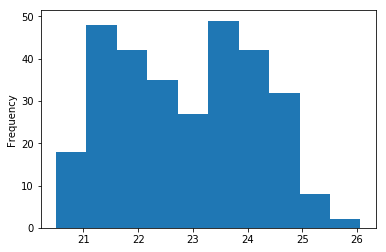

In [38]:
#efficiencies.PEAKMAG_g.plot.hist()
df = efficiencies[efficiencies['PEAKMAG_g'] > 0]
df = df[df['PEAKMAG_g'] <99]
df.PEAKMAG_g.plot.hist()

In [28]:
#df.PEAKMAG_g.mean
# mag 23.5 = snr 5.0 for 40sec exps
p = 0.
for mag in df.PEAKMAG_g:
    if mag <= 23.5:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

193.0
303
0.63696369637


In [29]:
# mag 23.99 = snr 5.0 for 90sec exps
p = 0.
for mag in df.PEAKMAG_g:
    if mag <= 23.99:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

228.0
303
0.752475247525


In [39]:
# mag 23.99 = snr 5.0 for 80sec exps
p = 0.
for mag in df.PEAKMAG_g:
    if mag <= 23.91:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

225.0
303
0.742574257426


# z band

In [40]:
df = efficiencies[efficiencies['PEAKMAG_z'] > 0]
df = df[df['PEAKMAG_z'] <99]

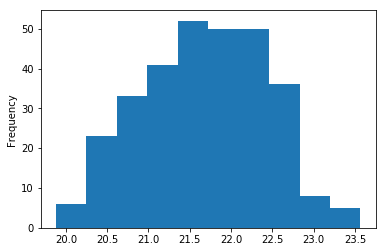

In [20]:
df.PEAKMAG_z.plot.hist()

In [31]:
# mag 22.3 = snr 5.0 for 40sec exps
p = 0.
for mag in df.PEAKMAG_z:
    if mag <= 22.3:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

233.0
304
0.766447368421


In [33]:
# mag 22.74 = snr 5.0 for 90sec exps
p = 0.
for mag in df.PEAKMAG_z:
    if mag <= 22.74:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

281.0
304
0.924342105263


In [41]:
# mag 22.74 = snr 5.0 for 80sec exps
p = 0.
for mag in df.PEAKMAG_z:
    if mag <= 22.66:
        p+=1.
print p
print len(df.PEAKMAG_g)
print p/len(df.PEAKMAG_g)

274.0
304
0.901315789474


In [24]:
#df.PEAKMAG_z.mean

# r band

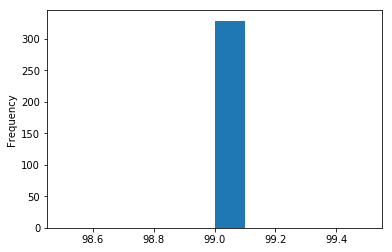

In [34]:
efficiencies.PEAKMAG_r.plot.hist()
# df = efficiencies[efficiencies['PEAKMAG_r'] > 0]
# df = df[df['PEAKMAG_r'] <99]
# df.PEAKMAG_r.plot.hist()

In [12]:
magz = np.sort(df['PEAKMAG_z'].values)
p = 0.9*(len(magz))
print magz[int(p)]
print p, int(p), np.floor(p)

21.375552081
296.1 296 296.0


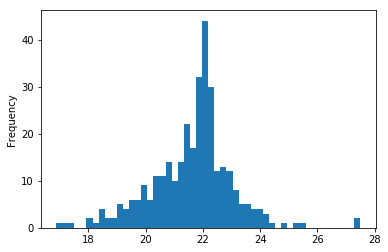

In [27]:
df.PEAKMAG_i.plot.hist(bins=50)

In [9]:
df = efficiencies[efficiencies['PEAKMAG_i'] > 0]

In [10]:
magi = np.sort(df['PEAKMAG_i'].values)

In [15]:
0.2*(len(magi))

65.4

In [17]:
magi[65]

20.5594151069

In [45]:
df = efficiencies[efficiencies['PEAKMAG_z'] > 0]
df = df[df['PEAKMAG_z'] < 99.]

In [43]:
yes = 0.0
for i in efficiencies['PEAKMAG_z'].values:
    if i < 22.28: #40 sec exp
        yes +=1.0
yes/len(efficiencies['PEAKMAG_z'].values)

0.993920972644377

In [ ]:
yes = 0.0
for i in efficiencies['PEAKMAG_z'].values:
    if i < 22.28: #40 sec exp
        yes +=1.0
yes/len(efficiencies['PEAKMAG_z'].values)

In [40]:
ee = []
for peakz, eff in zip(efficiencies['PEAKMAG_z'].values, efficiencies["EFFICIENCY"].values):
    if peakz < 21.28:
         ee.append(eff)
meanee = sum(ee)/len(ee)
print meanee

0.6785370462145851


In [4]:
print "MEAN:", efficiencies["PEAKMAG_z"].mean()
print "Max:", efficiencies["PEAKMAG_z"].max()
print "Min:", efficiencies["PEAKMAG_z"].min()

MEAN: 20.474585595873556
Max: 22.3964404638
Min: 18.473422404


In [54]:
print efficiencies["EFFICIENCY"].mean()
print efficiencies["EFFICIENCY"].min(), efficiencies["EFFICIENCY"].max()

0.6686839108434465
0.0572082379863 1.0


In [55]:
len(efficiencies['EFFICIENCY'].values)

329

In [42]:
y = 0
for i in efficiencies['EFFICIENCY'].values:
    if i > 0.66:
        y += 1.0
print y/len(efficiencies['EFFICIENCY'].values)

0.565349544073


80 sec exposure --> mag 22.68 for snr = 5
60 sec --> mag 22.52
40 sec --> mag 22.3